In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ff98bc3e5f723585ef1a6d2619a76b39144d73ce62443eab547ec5a6fc666f94
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
# --- Cell 1: Imports (Keep as is) ---
import os, random, shutil, math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
import pandas as pd # For saving report

In [5]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/My Drive/bn_image.zip" -d "/content/dataset"

import os
dataset_path = '/content/dataset'
print("Top-level folders:", os.listdir(dataset_path))


Mounted at /content/drive
Top-level folders: ['bn_images']


In [6]:
import os, random, shutil, math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
import os

dataset_path = '/content/dataset'

for root, dirs, files in os.walk(dataset_path):
    print("Current path:", root)
    print("Folders:", dirs)
    print("Files:", files[:5])  # show first 5 files if any
    print("------")


Current path: /content/dataset
Folders: ['bn_images']
Files: []
------
Current path: /content/dataset/bn_images
Folders: ['BIRAD1', 'Birad4', 'Birad5', 'Birad3']
Files: []
------
Current path: /content/dataset/bn_images/BIRAD1
Folders: ['b1']
Files: []
------
Current path: /content/dataset/bn_images/BIRAD1/b1
Folders: []
Files: ['2013_BC011242_ CC_R.jpg', '2016_BC003289_ MLO_L.jpg', '2018_BC0021747_ MLO_R.jpg', '2013_BC010921_ MLO_R.jpg', '2019_BC0022381_ MLO_L.jpg']
------
Current path: /content/dataset/bn_images/Birad4
Folders: ['b4']
Files: []
------
Current path: /content/dataset/bn_images/Birad4/b4
Folders: []
Files: ['2017_BC019602_ CC_L.jpg', '2017_BC0020521_ MLO_L.jpg', '2018_BC0023145_ MLO_R.jpg', '2018_BC0022402_ CC_L.jpg', '2018_BC0024341_ CC_R.jpg']
------
Current path: /content/dataset/bn_images/Birad5
Folders: ['Birad5']
Files: []
------
Current path: /content/dataset/bn_images/Birad5/Birad5
Folders: []
Files: ['2018_BC0022025_ MLO_R.jpg', '2018_BC0022025_ MLO_L.jpg', '20

In [8]:
root_folder = '/content/dataset/bn_images'  # point to bn_images folder
main_dest = '/content/breast_cancer_final'  # final organized dataset

# Mapping nested folders to classes
classes = {
    'Normal': ['BIRAD1'],
    'Benign': ['Birad3'],
    'Malignant': ['Birad4', 'Birad5']
}

# Create class folders
os.makedirs(main_dest, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(main_dest, cls), exist_ok=True)

# Recursive copy function
def copy_images_recursive(src_folder, dest_folder):
    count = 0
    for root, dirs, files in os.walk(src_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                shutil.copy(os.path.join(root, file), dest_folder)
                count += 1
    return count

# Copy images to clean dataset folder
for cls, birad_list in classes.items():
    dest_folder = os.path.join(main_dest, cls)
    total = 0
    for birad in birad_list:
        src_folder = os.path.join(root_folder, birad)
        if os.path.exists(src_folder):
            total += copy_images_recursive(src_folder, dest_folder)
        else:
            print(f"❌ Folder not found: {src_folder}")
    print(f"✅ {cls} → {total} images copied")

# Verify
for cls in classes:
    path = os.path.join(main_dest, cls)
    print(cls, "→", len(os.listdir(path)), "images")


✅ Normal → 1865 images copied
✅ Benign → 387 images copied
✅ Malignant → 126 images copied
Normal → 1865 images
Benign → 387 images
Malignant → 124 images


In [9]:
split_root = '/content/bc_split'
img_ext = ('.jpg', '.jpeg', '.png')
split_ratio = {"train":0.7, "val":0.15, "test":0.15}

os.makedirs(split_root, exist_ok=True)

for cls in classes:
    src = os.path.join(main_dest, cls)
    imgs = [os.path.join(src, f) for f in os.listdir(src) if f.lower().endswith(img_ext)]
    random.shuffle(imgs)
    n = len(imgs)
    n_train = int(n*split_ratio["train"])
    n_val = int(n*split_ratio["val"])

    parts = {
        "train": imgs[:n_train],
        "val": imgs[n_train:n_train+n_val],
        "test": imgs[n_train+n_val:]
    }

    for part, files in parts.items():
        outdir = os.path.join(split_root, part, cls)
        os.makedirs(outdir, exist_ok=True)
        for f in files:
            shutil.copy(f, outdir)

# Print split counts
for part in ["train","val","test"]:
    print(part, {cls: len(os.listdir(os.path.join(split_root,part,cls))) for cls in classes})


train {'Normal': 1305, 'Benign': 270, 'Malignant': 86}
val {'Normal': 279, 'Benign': 58, 'Malignant': 18}
test {'Normal': 281, 'Benign': 59, 'Malignant': 20}


In [10]:
# --- Cell 4: Data Augmentation and Generator Initialization (Keep as is) ---
img_size = (224,224)
batch_size = 16
split_root = '/content/bc_split' # Ensure this path is correct

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Test datagen remains rescaling only (no augmentation for evaluation)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_root, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_gen = test_datagen.flow_from_directory(
    os.path.join(split_root, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    os.path.join(split_root, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print("Class indices:", train_gen.class_indices)
y_train = train_gen.classes
classes_ids = np.unique(y_train)
cw = class_weight.compute_class_weight('balanced', classes=classes_ids, y=y_train)
class_weights = dict(zip(classes_ids, cw)) # Use dictionary mapping for reliability
print("Class weights:", class_weights)



Found 1661 images belonging to 3 classes.
Found 355 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
Class indices: {'Benign': 0, 'Malignant': 1, 'Normal': 2}
Class weights: {np.int32(0): np.float64(2.050617283950617), np.int32(1): np.float64(6.437984496124031), np.int32(2): np.float64(0.4242656449553001)}


In [11]:
# --- Cell 5: Model Definition (Keep as is) ---
base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base.input, outputs=out)
# Use a standard learning rate for initial training
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,278 (16.70 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
# --- Cell 6: Stage 1 Training (MODIFIED: CLASS WEIGHTS REMOVED) ---
print("\n--- Stage 1: Training Classification Head (Weights Removed) ---")
PATIENCE = 6 # Reduced patience for faster convergence
MAX_EPOCHS_STAGE1 = 20 # Sufficient epochs for a stable run

ckpt = "/content/effnet_stage1.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=MAX_EPOCHS_STAGE1,
    # CRITICAL FIX: REMOVE CLASS WEIGHTS TO PREVENT INSTABILITY AND COLLAPSE
    # class_weight=class_weights,
    callbacks=callbacks
)


--- Stage 1: Training Classification Head (Weights Removed) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7554 - loss: 0.7232

104/104 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7556 - loss: 0.7228 - val_accuracy: 0.7859 - val_loss: 0.6387 - learning_rate: 1.0000e-04
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.7915 - loss: 0.6330

104/104 ━━━━━━━━━━━━━━━━━━━━ 88s 850ms/step - accuracy: 0.7914 - loss: 0.6332 - val_accuracy: 0.7859 - val_loss: 0.6381 - learning_rate: 1.0000e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 779ms/step - accuracy: 0.7626 - loss: 0.7128 - val_accuracy: 0.7859 - val_loss: 0.6385 - learning_rate: 1.0000e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 671ms/step - accuracy: 0.7765 - loss: 0.6729 - val_accuracy: 0.7859 - val_loss: 0.6426 - learning_rate: 1.0000e-04
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.7841 - loss: 0.6561

104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 736ms/step - accuracy: 0.7842 - loss: 0.6560 - val_accuracy: 0.7859 - val_loss: 0.6378 - learning_rate: 1.0000e-04
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.7937 - loss: 0.6375

104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 780ms/step - accuracy: 0.7936 - loss: 0.6376 - val_accuracy: 0.7859 - val_loss: 0.6371 - learning_rate: 1.0000e-04
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.7945 - loss: 0.6305

104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 799ms/step - accuracy: 0.7944 - loss: 0.6307 - val_accuracy: 0.7859 - val_loss: 0.6367 - learning_rate: 1.0000e-04
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 688ms/step - accuracy: 0.7724 - loss: 0.6627 - val_accuracy: 0.7859 - val_loss: 0.6372 - learning_rate: 1.0000e-04
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 744ms/step - accuracy: 0.8017 - loss: 0.6292 - val_accuracy: 0.7859 - val_loss: 0.6384 - learning_rate: 1.0000e-04
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 87s 841ms/step - accuracy: 0.7910 - loss: 0.6360 - val_accuracy: 0.7859 - val_loss: 0.6369 - learning_rate: 1.0000e-04
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 786ms/step - accuracy: 0.7781 - loss: 0.6633 - val_accuracy: 0.7859 - val_loss: 0.6377 - learning_rate: 5.0000e-05
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 672ms/step - accuracy: 0.7813 - loss: 0.6565 - val_accuracy: 0.7859 - val_loss: 0.6368 - learning_rate: 5.0000e-05
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step

104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 740ms/step - accuracy: 0.7839 - loss: 0.6398 - val_accuracy: 0.7859 - val_loss: 0.6365 - learning_rate: 5.0000e-05
Epoch 14/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 779ms/step - accuracy: 0.7919 - loss: 0.6348 - val_accuracy: 0.7859 - val_loss: 0.6367 - learning_rate: 5.0000e-05
Epoch 15/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 741ms/step - accuracy: 0.8005 - loss: 0.6307 - val_accuracy: 0.7859 - val_loss: 0.6382 - learning_rate: 5.0000e-05
Epoch 16/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 71s 686ms/step - accuracy: 0.7840 - loss: 0.6490 - val_accuracy: 0.7859 - val_loss: 0.6367 - learning_rate: 5.0000e-05
Epoch 17/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.7955 - loss: 0.6278

104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 720ms/step - accuracy: 0.7954 - loss: 0.6279 - val_accuracy: 0.7859 - val_loss: 0.6365 - learning_rate: 2.5000e-05
Epoch 18/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 787ms/step - accuracy: 0.7869 - loss: 0.6382 - val_accuracy: 0.7859 - val_loss: 0.6367 - learning_rate: 2.5000e-05
Epoch 19/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.7900 - loss: 0.6390

104/104 ━━━━━━━━━━━━━━━━━━━━ 86s 821ms/step - accuracy: 0.7899 - loss: 0.6391 - val_accuracy: 0.7859 - val_loss: 0.6365 - learning_rate: 2.5000e-05
Epoch 20/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.7878 - loss: 0.6356

104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 696ms/step - accuracy: 0.7877 - loss: 0.6356 - val_accuracy: 0.7859 - val_loss: 0.6364 - learning_rate: 1.2500e-05


In [13]:
# --- Cell 7: Define ckpt2 and revert removal of class_weight ---
# Define the checkpoint path for fine-tuning
ckpt2 = "/content/effnet_finetune_stage2.h5"

# ... rest of the fine-tuning block below ...

# Re-run this entire section to ensure consistency:
# --- Cell 5: Model Definition (MODIFIED: Reset Model, Max Dropout) ---
base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) # Max Dropout to prevent collapsing
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base.input, outputs=out)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,278 (16.70 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# --- Cell 6: Stage 1 Training (MODIFIED: Reimplement Weights, Max Patience) ---
print("\n--- Stage 1: Training Classification Head (Weights Re-implemented) ---")
PATIENCE = 10 # Max patience
MAX_EPOCHS_STAGE1 = 80 # Max epochs

ckpt = "/content/effnet_stage1.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=MAX_EPOCHS_STAGE1,
    class_weight=class_weights, # CRITICAL: Reintroduce weights
    callbacks=callbacks
)


--- Stage 1: Training Classification Head (Weights Re-implemented) ---
Epoch 1/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.4359 - loss: 1.0882

104/104 ━━━━━━━━━━━━━━━━━━━━ 120s 962ms/step - accuracy: 0.4350 - loss: 1.0886 - val_accuracy: 0.7859 - val_loss: 0.9958 - learning_rate: 1.0000e-04
Epoch 2/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 670ms/step - accuracy: 0.4695 - loss: 1.0824 - val_accuracy: 0.1634 - val_loss: 1.2472 - learning_rate: 1.0000e-04
Epoch 3/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 737ms/step - accuracy: 0.2303 - loss: 1.2149 - val_accuracy: 0.1634 - val_loss: 1.0707 - learning_rate: 1.0000e-04
Epoch 4/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 84s 807ms/step - accuracy: 0.2414 - loss: 1.1240 - val_accuracy: 0.7859 - val_loss: 1.0350 - learning_rate: 1.0000e-04
Epoch 5/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 77s 741ms/step - accuracy: 0.4717 - loss: 1.0813 - val_accuracy: 0.1634 - val_loss: 1.0753 - learning_rate: 1.0000e-04
Epoch 6/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 781ms/step - accuracy: 0.3512 - loss: 1.0698 - val_accuracy: 0.0507 - val_loss: 1.1566 - learning_rate: 1.0000e-04
Epoch 7/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 75s 725ms/step -

In [15]:
# --- Cell 7: Stage 2 Fine-Tuning (MODIFIED: Reimplement Weights) ---
print("\n--- Stage 2: Fine-Tuning EfficientNet Base (Weights Re-implemented) ---")
base.trainable = True
N = 40
for layer in base.layers[:-N]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

MAX_EPOCHS_STAGE2 = 40
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint(ckpt2, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=MAX_EPOCHS_STAGE2,
    class_weight=class_weights, # CRITICAL: Reintroduce weights
    callbacks=callbacks2
)


--- Stage 2: Fine-Tuning EfficientNet Base (Weights Re-implemented) ---
Epoch 1/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.3034 - loss: 1.0553

104/104 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3038 - loss: 1.0559 - val_accuracy: 0.7859 - val_loss: 0.9722 - learning_rate: 1.0000e-05
Epoch 2/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.3159 - loss: 1.0603

104/104 ━━━━━━━━━━━━━━━━━━━━ 84s 807ms/step - accuracy: 0.3162 - loss: 1.0609 - val_accuracy: 0.7859 - val_loss: 0.9545 - learning_rate: 1.0000e-05
Epoch 3/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 85s 822ms/step - accuracy: 0.3328 - loss: 1.1389 - val_accuracy: 0.7859 - val_loss: 0.9820 - learning_rate: 1.0000e-05
Epoch 4/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 85s 817ms/step - accuracy: 0.3320 - loss: 1.1266 - val_accuracy: 0.7859 - val_loss: 1.0479 - learning_rate: 1.0000e-05
Epoch 5/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 729ms/step - accuracy: 0.3425 - loss: 1.1325 - val_accuracy: 0.7859 - val_loss: 1.0473 - learning_rate: 1.0000e-05
Epoch 6/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 74s 714ms/step - accuracy: 0.3359 - loss: 1.1289 - val_accuracy: 0.7859 - val_loss: 1.0734 - learning_rate: 1.0000e-05
Epoch 7/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 78s 744ms/step - accuracy: 0.3632 - loss: 1.1103 - val_accuracy: 0.1634 - val_loss: 1.0853 - learning_rate: 1.0000e-05
Epoch 8/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 794ms/step - 

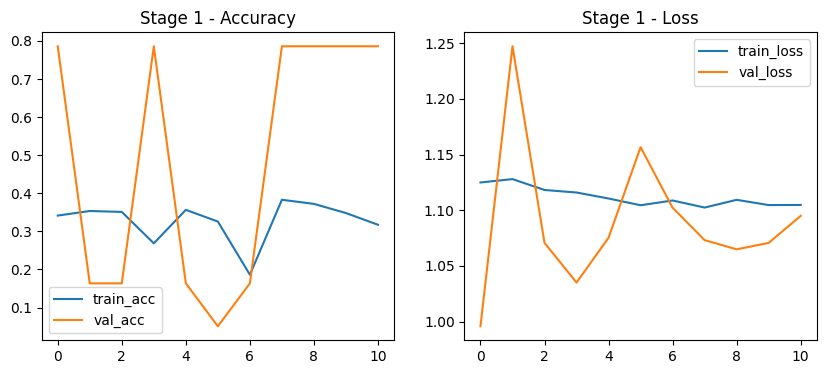

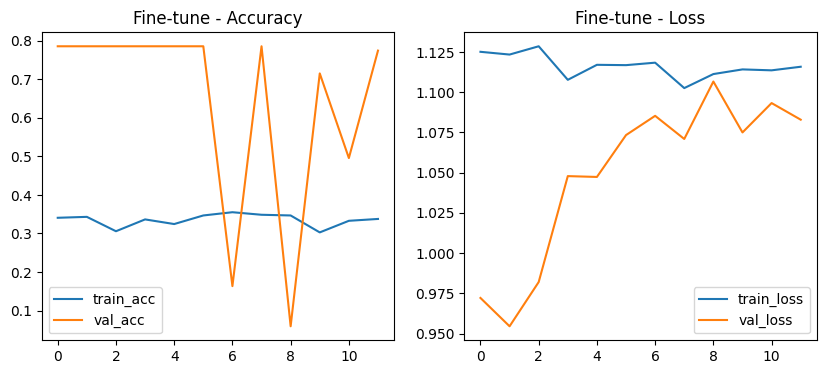

In [16]:
# --- Cell 8: Plot History (Keep as is) ---
def plot_hist(h, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title(title + " - Accuracy")

    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.legend(); plt.title(title + " - Loss")
    plt.show()

plot_hist(history1, "Stage 1")
try:
    plot_hist(history2, "Fine-tune")
except:
    pass


23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 957ms/step - accuracy: 0.4843 - loss: 1.0890

🔥 Final Test Accuracy: 78.06%

23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 781ms/step
Manual accuracy: 0.7805555555555556

Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        59
   Malignant       0.00      0.00      0.00        20
      Normal       0.78      1.00      0.88       281

    accuracy                           0.78       360
   macro avg       0.26      0.33      0.29       360
weighted avg       0.61      0.78      0.68       360



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


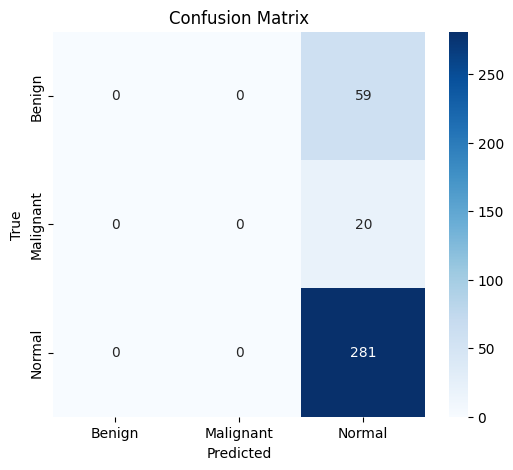

Saved model and classification_report.csv


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# --- Cell 9: Final Evaluation (Keep as is) ---
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n🔥 Final Test Accuracy: {test_acc*100:.2f}%\n")

# Manual evaluation
y_prob = model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

manual_acc = accuracy_score(y_true, y_pred)
print("Manual accuracy:", manual_acc)

print("\nClassification Report:")
target_names = list(train_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()
model.save("/content/breast_effnet_model.h5")

report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
pd.DataFrame(report).to_csv("/content/classification_report.csv")
print("Saved model and classification_report.csv")


--- Explainable AI ---
Starting SHAP KernelExplainer...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 1/6 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 3/6 [01:28<01:04, 21.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 4/6 [02:10<01:00, 30.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 5/6 [02:52<00:34, 34.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 6/6 [03:34<00:00, 37.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 7it [04:17, 42.91s/it]


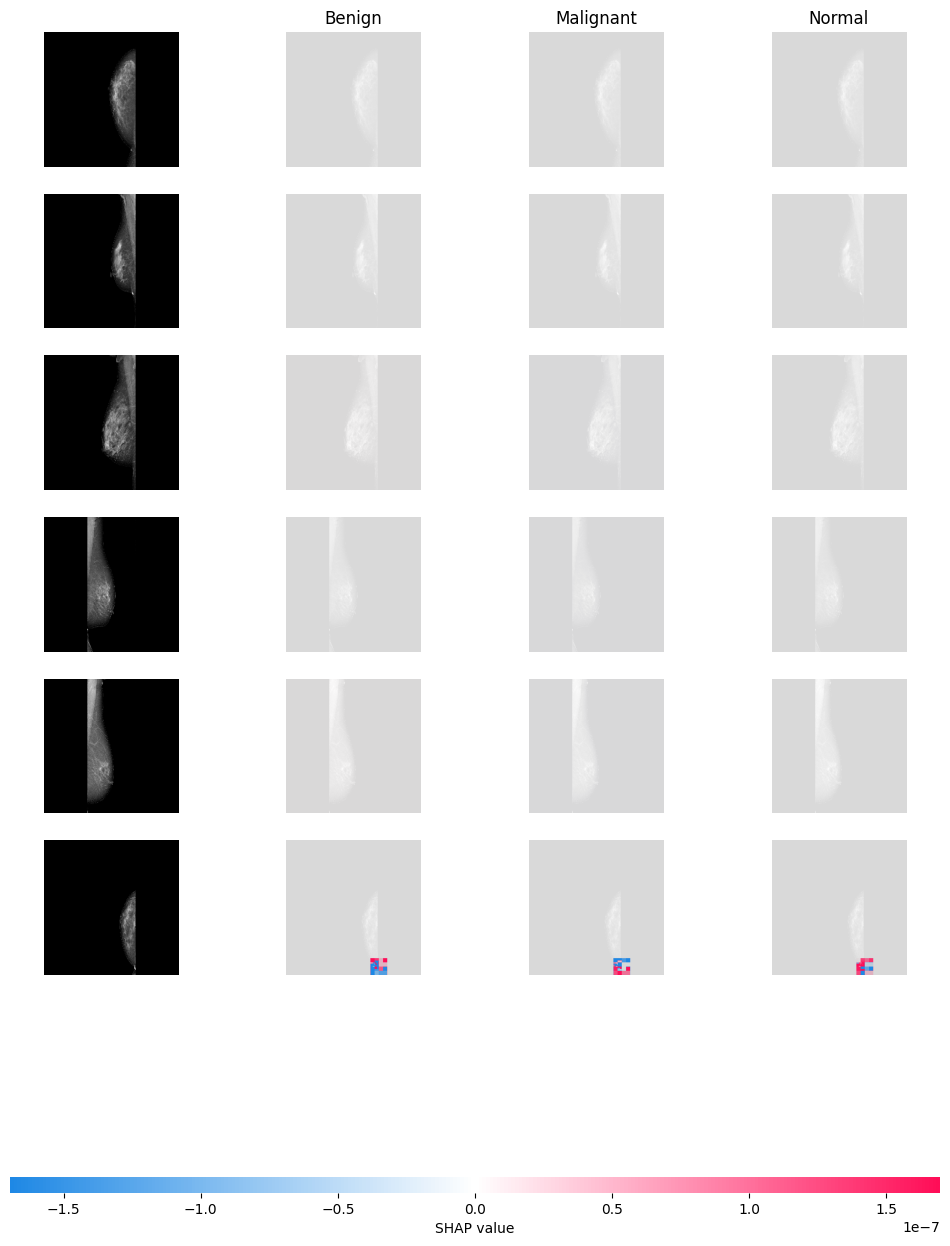


Starting LIME Explainer...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

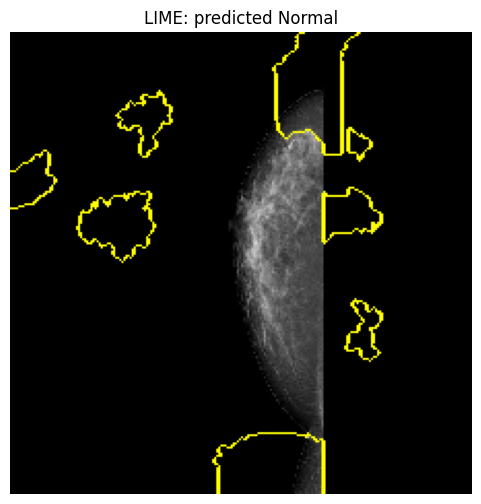

In [18]:
# --- Cell 10: SHAP and LIME (Keep as is - previous type fixes should now be sufficient) ---
print("\n--- Explainable AI ---")

# SHAP setup
# Pick small subset of test images
test_batch, _ = next(test_gen)
to_explain = test_batch[:6]

print("Starting SHAP KernelExplainer...")
# Ensure model prediction is used correctly
masker = shap.maskers.Image("inpaint_telea", to_explain.shape[1:])
explainer = shap.Explainer(model, masker, output_names=target_names)
shap_values = explainer(to_explain)

# Display SHAP plot
shap.image_plot(shap_values, to_explain) #


# LIME setup
print("\nStarting LIME Explainer...")
def lime_predict(images):
    images = np.array(images)
    # Ensure images are scaled correctly for the model if LIME rescales them
    preds = model.predict(images)
    return preds

# choose one test image
img = test_batch[0]
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img.astype('double'),
    lime_predict,
    top_labels=num_classes, # Explain all possible labels
    hide_color=0,
    num_samples=1000
)

pred_class_idx = np.argmax(model.predict(img[np.newaxis,...]))
pred_class_name = target_names[pred_class_idx]
temp, mask = explanation.get_image_and_mask(pred_class_idx, positive_only=True, num_features=8, hide_rest=False)
plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME: predicted {pred_class_name}")
plt.axis('off')
plt.show() #